Task 1 code
\
Authors: Chloé Tap, Evan Meltz, Giulia Rivetti
\
Group 36


In [ ]:
#importing files as saved from Google drive - change path for another source
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from scipy.spatial.distance import cdist
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
#!pip install umap - if needed
!pip install umap-learn
import umap
import itertools
from sklearn.datasets import fetch_openml
import seaborn as sns

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=5b8a1fc41b7c3788e611e66b5bec0a8207fb144c4c5a0997ab55d317d7144169
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=3aab62d806087d446bd6a75b11d1d09cd582b535623a6838141f76c6fc764983
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


Part 1: The goal is to calculate the centres of each digit "cloud" using the training data. Each row in the train_in file is a 256-dimensional vector which corresponds to a digit from 0 to 9 which is given in the train_out file. After importing both files into dataframes and concatenating them, we sort the rows by digit label and for each group of vectors corresponding to the same digit, we calculate an average for each co-ordinate in the 256-dimensional vector which corresponds to the "centre" vector for each digit.

In [ ]:
#load in csv files for train_in and train_out into dataframes
#change path for another source - i.e. for TAs
train_in_dataframe = pd.read_csv('/content/drive/MyDrive/IDL MNIST files/train_in.csv', header=None)
train_out = pd.read_csv('/content/drive/MyDrive/IDL MNIST files/train_out.csv',names=['True value'],dtype=int, header=None)
#same for test_in and test_out
test_in_dataframe = pd.read_csv('/content/drive/MyDrive/IDL MNIST files/test_in.csv', header=None)
test_out = pd.read_csv('/content/drive/MyDrive/IDL MNIST files/test_out.csv',names=['True value'],dtype=int, header=None)

#add a column to identify rows with the same digit label (in train_out file)
train_in_dataframe['labels'] = train_out

#sort the dataframe by label (digit 0 rows first and so on until digit 9 rows)
matrix = train_in_dataframe.sort_values(by=['labels'])

In [ ]:
#calculates centre (mean) vectors for each digit d (0-9)
#group dataframe by "labels" column (all 0s, 1s etc together) and calculates the mean for each
#the result is a dataframe with 10 rows corresponding to centres for each digit from 0 to 9
avgs = matrix.groupby(['labels']).mean()

#indexing to show each row, first index is the row index
avgs.loc[0,:] #row for digit 0

mean_arrs = avgs.to_numpy()
#each digit's "mean" is inputted into an array where each index 0-9 gives the array for each mean
#can be viewed/accessed by typing mean_arrs[i] where i = digit

In [ ]:
#part 1: distances between centres for digits 0-9

#get names of rows (i.e. digits d)
data_top = avgs.head(10)
ind = list(data_top.index)

#empty dictionary to store data
dist_dict = {'digit 1':[],'digit 2':[],'distance':[]}

#loop through each pairing and calculate distance, saving to new pandas dataframe
for i,j in list(itertools.product(ind,ind)):
    #calculate distance between each pair
    dist = np.linalg.norm(avgs.loc[i,:].values - avgs.loc[j,:].values)
    #append to individual lists
    dist_dict['digit 1'].append(i)
    dist_dict['digit 2'].append(j)
    dist_dict['distance'].append(dist)

#make a dataframe with distance where the columns are "digit 1", "digit 2", "distance between centres"
dist_df = pd.DataFrame(dist_dict)
sorted = dist_df.sort_values(by='distance')

#matrix like object to show distance between centres for each combination
dist_matrix = dist_df.pivot(index='digit 2', columns='digit 1', values='distance')
#dist_matrix

#make ordered list of smallest to largest distances between digits to see which are most difficult to distinguish between
#~sorted.duplicated('distance') ensures we disregard any repeats (since each digit pair will be inputted twice, for each combination)
sorted.loc[(sorted['distance']>0) &(~sorted.duplicated('distance'))].head()

,digit 1,digit 2,distance
97,9,7,5.426474
49,4,9,6.010408
35,3,5,6.118750
89,8,9,6.401166
56,5,6,6.698692


The top 5 results (in ascending order) for digits with the closest distance are: (7,9), (4,9), (3,5), (8,9) and (5,6). This makes sense since each of these combinations are relatively similar in shape to one another, hence it is more difficult to distinguish one compared to the other.

Part 2: In all three dimensionality reduction regimes, we find that 7 & 9 have a very strong overlap and are most difficult to distinguish - which is the same result we saw in part 1.

Principal Component Analysis

Shape of pca_reduced.shape =  (1707, 2)
[0.16019309 0.07714897]


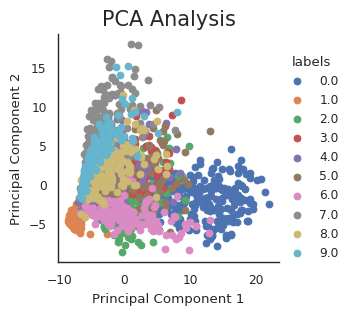

In [ ]:
# PCA using scikit learn
from sklearn import decomposition
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

sns.set(context="paper", style="white")

# Data preprocessing: standardizing the data
# To standardized all the data to have mean = 0 and standard deviation = 1
standardized_data = StandardScaler().fit_transform(train_in_dataframe.values)
sample_data = standardized_data

pca = decomposition.PCA() # Initialization of PCA
pca.n_components = 2 # 2 principal components -->  2 dimensional visualization
pca_data = pca.fit_transform(sample_data) # Apply PCA to transform data
# Shape of sample_data wrt to original dataset has been reduced from
# (1707, 256) to (1707, 2), so now 2 dimensional
print("Shape of pca_reduced.shape = ", pca_data.shape)

# To check that first and second principal components are the one
# retaining the largest percentage of variance --> more info
print(pca.explained_variance_ratio_)

# Attaching the labels for each 2D data point
pca_data = np.vstack((pca_data.T, train_in_dataframe['labels'])).T
# Create a new dataframe to plot the resulting data
pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal", "labels"))

sn.FacetGrid(pca_df, hue="labels").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Analysis', fontsize=15)
plt.show()
# PCA plot used to group similarity
# Digit 9 and digit 0 are separated from each other, however there is an overlapping of labels
# because we reduced the original datset to only 2 dimensions

t-distributed Stochastic Neighbor Embedding

In [ ]:
#TSNE
from sklearn.manifold import TSNE

# TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, random_state=42)
tsne_result = tsne.fit_transform(train_in_dataframe.values)
print(tsne_result.shape, tsne.kl_divergence_)

# Plot results
# concatenates labels column with each row of the tsne results so we can plot the digit labels
tsne_result = np.vstack((tsne_result.T, train_in_dataframe['labels'])).T
# Create a new dataframe to plot the resulting data
tsne_df = pd.DataFrame(data=tsne_result, columns=("1st_tsne", "2nd_tsne", "labels"))

(1707, 2) 0.839674711227417


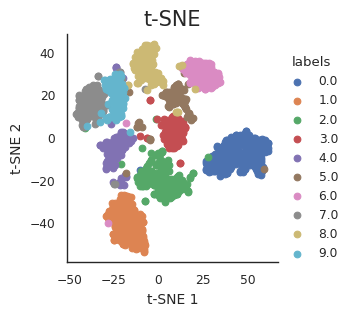

In [ ]:
#plot results for t-SNE
ax = sn.FacetGrid(tsne_df, hue="labels")
ax.map(plt.scatter, '1st_tsne', '2nd_tsne').add_legend()
plt.title('t-SNE', fontsize = 15)
ax.set_xlabels('t-SNE 1',fontsize = 10)
ax.set_ylabels('t-SNE 2', fontsize = 10)
plt.show()

UMAP

(1707, 2)


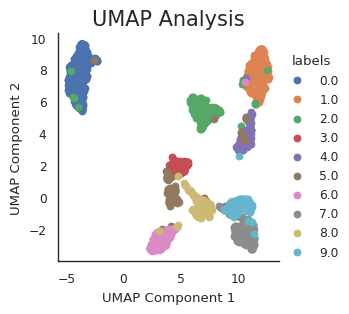

In [ ]:
# UMAP
#https://pypi.org/project/umap-learn/

#complete umap reduction based on UMAP module
embedding = umap.UMAP().fit_transform(train_in_dataframe.values)
print(embedding.shape)

#reshape data
umap_result = np.vstack((embedding.T, train_in_dataframe['labels'])).T
# Create a new dataframe to plot the resulting data
umap_df = pd.DataFrame(data=umap_result, columns=("1st_principal", "2nd_principal", "labels"))
sn.FacetGrid(umap_df, hue="labels").map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.title('UMAP Analysis', fontsize=15)
plt.show()

Part 3: Here we construct a nearest mean classifier which uses the centres calculated in part 1. For each vector for an unknown digit, we determine the distance between this vector and each of the 10 centres. The smallest distance corresponds to the closest centre to the vector and thus the digit label for that vector. The predicted digit and distance are stored in a result dictionary which is then converted to a dataframe which also includes the true digit label from the output files. This process was conducted on both the training and test data and confusion matrices were created to show the number of correctly classified digits for each label. Accuracy of the classifer for the training data is ~86% while the accuracy for the test data is ~80%.

In [ ]:
#part 3 nearest mean classifier

#remove "labels" column as digit labels are not needed for this part
train_in = train_in_dataframe.drop('labels',axis='columns')

#need to calculate distance between mean for each digit and every vector, only saving the smallest distance for each one
def nearest_mean_classifier(data,centres,true,dig):
  #store results in a dictionary to convert to dataframe at the end
  result_dict = {'pred_digit':[],'distance':[]}
  #create a loop to classify each vector j by comparing to each centre i
  for j in range(len(data)): #over all vectors
    vec_j = data.loc[j,:]
    #make list of ALL distances calculated
    dist = []
    for i in range(dig): #loop over each centre for digits 0 to 9
      #takes each centre from array one at a time
      m_dig = centres[i]
      #adds distance between centre i and vector j to list
      dist.append(np.linalg.norm(m_dig - vec_j))
    #only select the smallest distance, index of dist is the digit label
    min_index = dist.index(min(dist))
    min_dist_i = dist[i]
    #append results to dictionary
    result_dict['pred_digit'].append(min_index)
    result_dict['distance'].append(min_dist_i)
  #convert dictionary to dataframe for convenience
  df = pd.DataFrame(result_dict)
  #add a column for the true digit label to compare with predictions
  df['true_digit'] = true
  return df

# training data classified
train_class = nearest_mean_classifier(train_in, avgs.to_numpy(), train_out, 10)
# percentage accuracy of mean classifier for test data
train_same = train_class['true_digit'] == train_class['pred_digit']
train_correct = (len(train_class.loc[train_same])/len(train_class))*100

# test data classified
test_class = nearest_mean_classifier(test_in_dataframe, avgs.to_numpy(),test_out,10)
# percentage accuracy of mean classifier for test data
test_same = test_class['true_digit'] == test_class['pred_digit']
test_correct = (len(test_class.loc[test_same])/len(test_class))*100
print('We found that', train_correct,' % of the training set vectors were correctly classified and', test_correct, '% of the test set vectors were correctly classified')

We found that 86.35032220269478  % of the training set vectors were correctly classified and 80.4 % of the test set vectors were correctly classified


In [ ]:
#Here we create confusion matrices for both the train and test data which has been classified above

#in confusion matrix, column labels are the true digits (from train/test out) and the rows labels are the predicted digits from the nearest mean classifier
train_matrix = pd.DataFrame(confusion_matrix(train_class['true_digit'],train_class['pred_digit'],normalize='true'))
test_matrix = pd.DataFrame(confusion_matrix(test_class['true_digit'],test_class['pred_digit'],normalize='true'))

percent1 = train_matrix.apply(lambda x: x*100)
train_matrix = percent1.rename_axis(index='True value', columns='Pred value')
percent2 = test_matrix.apply(lambda x: x*100)
test_matrix = percent2.rename_axis(index='True value', columns='Pred value')

In [ ]:
train_matrix

Pred value,0,1,2,3,4,5,6,7,8,9
True value,,,,,,,,,,
0,84.952978,0.000000,0.000000,0.000000,0.626959,1.253918,11.285266,0.000000,1.880878,0.000000
1,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.485149,0.000000,82.673267,4.455446,4.455446,0.495050,1.485149,1.980198,2.970297,0.000000
3,0.000000,0.000000,1.526718,91.603053,0.763359,2.290076,0.000000,0.763359,2.290076,0.763359
4,0.000000,6.557377,0.819672,0.000000,77.868852,0.000000,2.459016,0.000000,0.000000,12.295082
5,3.409091,0.000000,2.272727,3.409091,4.545455,76.136364,3.409091,1.136364,2.272727,3.409091
6,6.622517,2.649007,3.311258,0.000000,1.324503,0.000000,85.430464,0.000000,0.662252,0.000000
7,0.000000,2.409639,0.000000,0.000000,1.204819,1.204819,0.000000,84.337349,0.602410,10.240964
8,0.694444,1.388889,0.694444,6.944444,1.388889,2.083333,0.694444,0.000000,84.027778,2.083333


We see that there is a low accuracy for digits 4 and 5, with 76/77% of digits classified correctly. All other digits have accuracies > 82%. ~12% of 4s misclassified as 9 and ~7% misclassified as 1, ~8% of 9s misclassified as 4, ~7% of 8s misclassified as 3. There are other discrepancies but these are the strongest ones that can be observed. Notice the strong misclassification of 4 as 9 and vice versa (12% and 8%), which was one of the top five minimum interclass distances found in the first part of this task. Similarly for 7 & 9 as ~10% and 5% misclassified digits for each combination, our top indistinguishable pair from part 1.

In [ ]:
test_matrix

Pred value,0,1,2,3,4,5,6,7,8,9
True value,,,,,,,,,,
0,79.464286,0.000000,1.339286,0.892857,1.785714,0.892857,10.267857,0.446429,4.464286,0.446429
1,0.000000,99.173554,0.000000,0.000000,0.000000,0.000000,0.826446,0.000000,0.000000,0.000000
2,1.980198,0.000000,68.316832,5.940594,7.920792,0.990099,0.000000,1.980198,12.871287,0.000000
3,3.797468,0.000000,3.797468,77.215190,1.265823,10.126582,0.000000,0.000000,1.265823,2.531646
4,1.162791,3.488372,3.488372,0.000000,80.232558,0.000000,1.162791,1.162791,0.000000,9.302326
5,5.454545,0.000000,0.000000,10.909091,5.454545,69.090909,1.818182,0.000000,0.000000,7.272727
6,7.777778,0.000000,2.222222,0.000000,2.222222,1.111111,86.666667,0.000000,0.000000,0.000000
7,0.000000,3.125000,1.562500,0.000000,7.812500,0.000000,0.000000,78.125000,0.000000,9.375000
8,3.260870,2.173913,0.000000,6.521739,3.260870,3.260870,0.000000,0.000000,79.347826,2.173913


Here we see the lowest accuracy for digits 2 and 5, with only 68/69% classified correctly. As in the case for the training data, the test data shows a high misclassification of 4 as 9 and vice versa (~9% for both). In addition ~13% of 2s are misclassifed as 8 (0% for the reverse!), ~10% of 0s are misclassified as 6 (and ~8% for the reverse), ~8% of 2s are misclassified as 4. Strikingly, ~11% of 5s are miclassified as 3 as well as 10% for the reverse case, and this pair is also in the top 5 minimum interclass distances from part 1. Also ~6% of 9s were misclassifed as 7, which is the pair with the smallest interclass distance which we found overall. Hence we managed to see confirm the trends observed from our interclass distance evaluation in the nearest mean classifier. As well as this, we showed that 7 & 9 were highly indistinguisable for the dimensionality reduction as well as the mean classifier. There are many other smaller discrepancies which have not been mentioned, but overall this indicates that the nearest mean classifier is not the best for use on the MNIST data. However it is a reasonable starting point to observe which pairs of digits are most difficult to distinguish from one another.

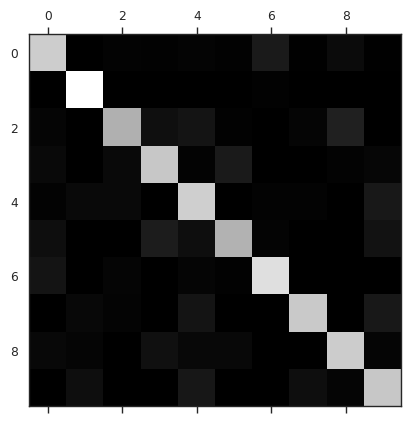

In [ ]:
#visualisation of confusion matrix for test data
plt.matshow(test_matrix, cmap=plt.cm.gray)
plt.show()

Part 4: Here we implement the K nearest neighbours classifier using sklearn. We use the training data to fit the model with k = 3 neighbours used, and make predictions for both the training and test data. Again the predicted digits are inputted into a dataframe along with the true values. Confusion matrices are evaluated for both data sets and are shown below. Accuracy of the classifer for the training data is ~98% while the accuracy for the test data is ~91%.

In [ ]:
#part 4: K nearest neighbours

def KNN(train_x, train_y, test_x, test_y):
  # implement k nearest neighbours algorithm for K = 3 neighbours
  knn = KNeighborsClassifier(n_neighbors=3)
  # fit using training data
  knn.fit(train_x.to_numpy(),train_y.to_numpy())
  # apply KNN to test data
  test_pred = knn.predict(test_x.to_numpy())
  # make a dataframe to store the predictions made to test data
  pred_df = pd.DataFrame(data=test_pred,columns=['Predicted value'])
  comp = pd.concat([test_y,pred_df],axis=1)
  # need to make a 10x10 confusion matrix which shows counts for correct and incorrect guesses for each digit in test set
  # normalized relative to "true" digits i.e. the outputs of test_out
  confusion_mat = pd.DataFrame(confusion_matrix(test_y.to_numpy(),test_pred, normalize='true'))
  # conversion to percentages for ease of reading
  percent = confusion_mat.apply(lambda x: x*100)
  df = percent.rename_axis(index='True value', columns='Pred value')
  return comp,df

# compute KNN and output confusion matrix for both training and test data
knn_test, knn_test_matrix = KNN(train_in, train_out, test_in_dataframe, test_out)
knn_train, knn_train_matrix = KNN(train_in, train_out, train_in, train_out)

# determine the accuracy of the KNN model on each data set
knn_acc1 = (len(knn_test.loc[knn_test['True value'] == knn_test['Predicted value']])/len(knn_test))*100
knn_acc2 = (len(knn_train.loc[knn_train['True value'] == knn_train['Predicted value']])/len(knn_train))*100

print('There are', knn_acc1,' % correctly classified digits in the test set and', knn_acc2, '% correctly classified digits in the train set using K nearest neighbours.')

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


There are 91.4  % correctly classified digits in the test set and 97.89103690685414 % correctly classified digits in the train set using K nearest neighbours.


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

[0.9519713261648747, 0.9396769048721512, 0.9426025964226306, 0.9373291488741403, 0.93791565913807, 0.9349865377030063, 0.9314760508308897, 0.9262026032823995, 0.9256195229030544, 0.9226955462948672]


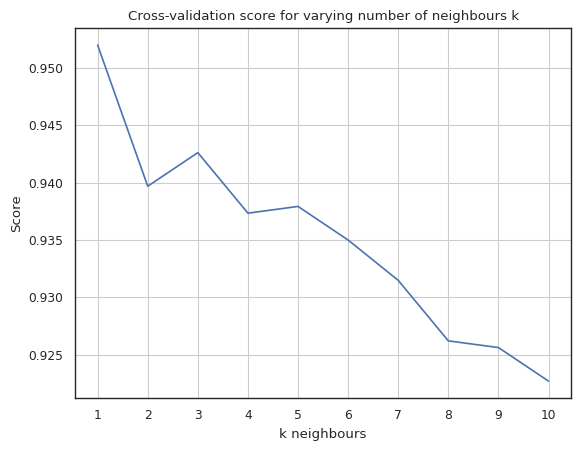

In [ ]:
#cross validation

#to store cross val scores for each k
scores = []

#from k = [1,10]
for k in np.arange(1,11):
  #initialize KNN for k neighbours
  kn = KNeighborsClassifier(n_neighbors=k)
  #performs cross validation for train data for each k neighbours 5 times
  cv_scores = cross_val_score(kn, train_in, train_out, cv=5)
  #takes a mean of the results
  m = np.mean(cv_scores)
  #add to list to visualize it
  scores.append(m)
print(scores)

#k = 3 chosen based on this plot
plt.plot(np.arange(1,11),scores)
plt.title('Cross-validation score for varying number of neighbours k')
plt.xlabel('k neighbours')
plt.ylabel('Score')
plt.xticks(np.arange(1,11))
plt.grid()

In [ ]:
#training confusion matrix for KNN
#true digits are along rows, predicted digits are along the columns
knn_train_matrix

Pred value,0,1,2,3,4,5,6,7,8,9
True value,,,,,,,,,,
0,99.686520,0.000000,0.313480,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,100.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.495050,0.000000,96.534653,0.000000,0.000000,0.000000,0.000000,1.980198,0.495050,0.495050
3,0.763359,0.000000,0.763359,98.473282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,1.639344,0.000000,0.000000,95.901639,0.000000,0.000000,0.000000,0.000000,2.459016
5,3.409091,0.000000,0.000000,0.000000,0.000000,95.454545,1.136364,0.000000,0.000000,0.000000
6,0.000000,0.662252,0.000000,0.000000,0.662252,0.000000,98.675497,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.602410,0.000000,0.000000,98.795181,0.000000,0.602410
8,0.694444,1.388889,0.000000,2.777778,0.694444,0.000000,0.000000,0.000000,94.444444,0.000000


There are only a few elements of note in the training data confusion matrix. As seen along the diagonal, the accuracy of correctly classifying a digit is very high (lowest is 94% for digit 8). One can notice that 5 is once again incorrectly classified as 0 for 3% of input data, showing a trend for the KNN algorithm on MNIST data. Similarly about 3% of 8s are missclassified as 3, 2% of 9s are missclassified as 7 and 2% of 4s are missclassified as 9. All other values are either very high (along the diagonal) or extremely low (off diagonals).

In [ ]:
#test data confusion matrix for KNN
#true digits are along rows, predicted digits are along the columns
knn_test_matrix

Pred value,0,1,2,3,4,5,6,7,8,9
True value,,,,,,,,,,
0,97.767857,0.000000,0.892857,0.000000,0.446429,0.000000,0.446429,0.000000,0.000000,0.446429
1,0.000000,98.347107,0.000000,0.000000,0.000000,0.000000,1.652893,0.000000,0.000000,0.000000
2,5.940594,1.980198,86.138614,0.990099,0.000000,0.000000,0.990099,0.990099,2.970297,0.000000
3,5.063291,0.000000,1.265823,88.607595,0.000000,2.531646,0.000000,0.000000,0.000000,2.531646
4,0.000000,2.325581,1.162791,0.000000,90.697674,1.162791,0.000000,1.162791,0.000000,3.488372
5,9.090909,0.000000,0.000000,16.363636,1.818182,67.272727,0.000000,0.000000,0.000000,5.454545
6,2.222222,1.111111,0.000000,0.000000,1.111111,0.000000,95.555556,0.000000,0.000000,0.000000
7,0.000000,4.687500,0.000000,1.562500,4.687500,0.000000,0.000000,87.500000,0.000000,1.562500
8,1.086957,2.173913,0.000000,4.347826,1.086957,0.000000,1.086957,2.173913,85.869565,2.173913


From the test data confusion matrix, we can clearly see that the digit 5 has quite a low accuracy compared to the other digits. For 67% of the test data, it is correctly classified as 5 - however 16% are classified as 3, 9% as 0 and 5% as 9. Other interesting observations include about 5-6% of digits 2 and 3 are misclassified as 0, 4% of 8s are missclassified as 3, nearly 5% of 7s are missclassified as 4 (same percentage as for 1), and 3% of 9s are missclassified as 7. The latter of these was found to be very distinct in part 1 of this exercise, with the smallest separation between the centres for digits 7 and 9.

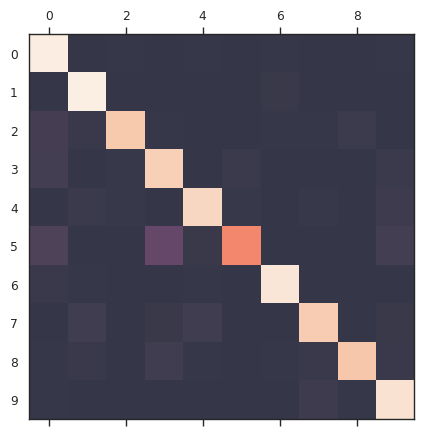

In [ ]:
fig,ax= plt.subplots(figsize = (10,5))
ax.matshow(knn_test_matrix,cmap=plt.cm.gray,alpha=0.8)
#ax.set_xticks(np.arange(0,10))
ax.set_yticks(np.arange(0,10))
#visualisation of discrepancies